In [17]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from guaranteed_control.intervals.interval import Interval, regroup_close, over_appr_union
import tensorflow.keras as keras
from guaranteed_control.nn_reachability.nn_reachability_tf import plot_interval, add_to_plot, reachMLP, reachMLP_pendulum
from tqdm import tqdm
import time
from guaranteed_control.closed_loop.reachability_closed_loop import interval_approximation, interval_approximation_naive
from guaranteed_control.problems.dynamics import F_car, F_double_integrator, F_pendulum
%load_ext autoreload
%autoreload 2

In [6]:
import guaranteed_control

In [2]:
def f_double_integrator(x, u):
  
    A = np.array([[1, 1], [0, 1]])
    B = np.expand_dims(np.array([0, 1]), axis=0).T
    

    return (A.dot(x.T) + B.dot(u)).T

In [3]:
def play_double_integrator(controller, input_interval = None, n_iterations=200):
    if input_interval is None:
        x0 = np.random.rand(1,2)
        print(x0)
    
    states = [x0[0]]
    actions = []

    for i in range(n_iterations):
        action = controller(x0)
        x0 = f_double_integrator(x0, action)

        states.append(x0[0])
        actions.append(action)
    
    return states, actions

In [7]:
model = keras.models.load_model("./models/mpc.tf")
states, actions = play_double_integrator(model)
states, actions = np.array(states), np.array(actions)

[[0.35083944 0.27895498]]


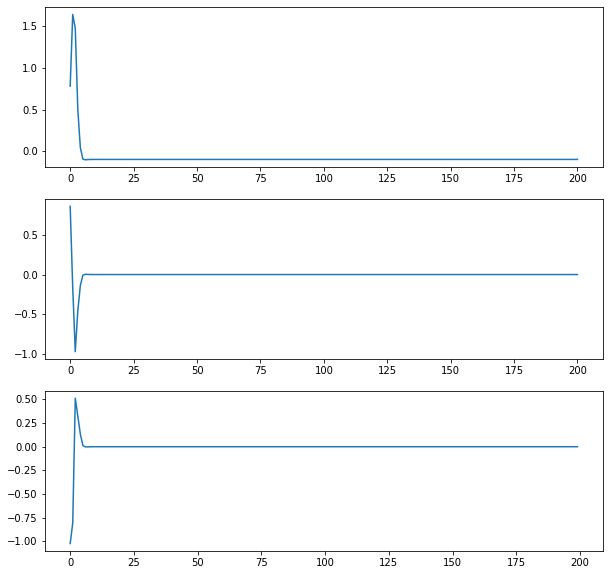

In [126]:
fig, axs = plt.subplots(3, figsize=(10, 10))
axs[0].plot(states[:, 0])
axs[1].plot(states[:, 1])
axs[2].plot(actions[:, 0])

In [ ]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/mpc.tf")
    state_interval = Interval(interval = [(0.2, 0.2001), (0.3, 0.3)])
    epsilon=0.00001
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-0.0001, 0.0001]])
    state_interval = interval_approximation_naive(10, model, F_double_integrator, state_interval, None, epsilon, epsilon_states=None, plot_jumps=2)

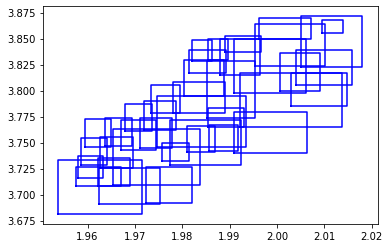

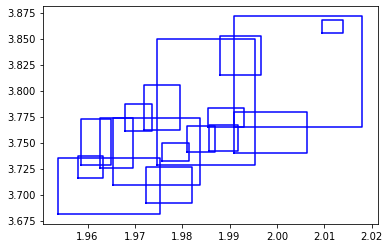

In [605]:
ax = plot_interval(state_interval[0], 0, 1)
for inter in state_interval[1:]:
    ax = add_to_plot(ax, inter, 0, 1)
plt.show()

new_intervals = regroup_close(state_interval, threshold=0.15)

ax = plot_interval(new_intervals[0], 0, 1)
for inter in new_intervals[1:]:
    ax = add_to_plot(ax, inter, 0, 1)
plt.show()


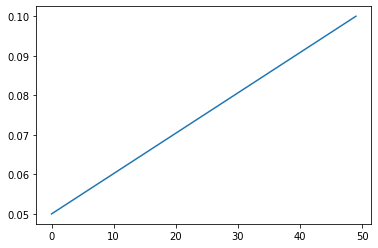

In [77]:
epsilons = np.ones(50)*0.05
iterations = np.arange(50)
epsilons = np.linspace(0.05, 0.1, 50)
plt.plot(epsilons)
plt.show()

In [23]:
#Use verbose 2 to understand what happends with the interval size and the divisions
#What is happening, is that as we advance, we need to divide more the interval
#Could increasing epsilon_actions with the iterations be the solution? 

def interval_approximation(T, model, F, state_interval, specification_interval, epsilon_nn, epsilon_actions=None, threshold=0.2, f= reachMLP, N=5000, plot_jumps=1, plot=False, verbose=0, epsilon_increase = "uniform", actions_increase="uniform"):

    """
    Awful complexity, it increases accuracy by a lot, but takes a long time to compute. The goal will be to improve that complexity
    """

    title = str(state_interval.intervals.tolist()).replace(" ", '')
    epsilons_nn = np.ones(T)*epsilon_nn
    epsilons_actions = np.ones(T)*epsilon_actions

    if actions_increase == "uniform":
        p = T//2
        mid_value = 1.5*epsilon_actions
        epsilons_actions[:p] = np.linspace(epsilon_actions, mid_value, p)
        epsilons_actions[p:] = np.linspace(mid_value, epsilon_actions, T-p)

    if epsilon_increase == "uniform":
        epsilons_nn = np.linspace(epsilon_nn, 1.5*epsilon_nn, T)



    if verbose == 2:
        time_reachability = []
        state_size = []
        errors = []
        action_size = []
        iteration = []


    if epsilon_actions == None:
        low, high = state_interval.high_low()
        random_points = [np.random.uniform(low[i], high[i], N) for i in range(len(high))]
        H = np.concatenate(random_points, axis=1)
        action_interval = f(model, H, epsilon_nn, N, input_y=1, output_y=0)

        return interval_approximation_naive(T, model, F, state_interval, epsilon_nn, specification_interval, f=f, plot_jumps=plot_jumps, plot=plot)
    
    if plot:
        ax_state = plot_interval(state_interval, 0, 1, "r")

    state_intervals = [state_interval]
    
    for t in tqdm(range(1, T+1)):
        state_intervals_new_step = []

        while len(state_intervals) != 0:
            state_interval = state_intervals.pop()
            low, high = state_interval.high_low()
            random_points = [np.random.uniform(low[i], high[i], N).reshape(N, 1) for i in range(len(high))]
            H = np.concatenate(random_points, axis=1)

            if verbose == 2:
                start_time = time.time()

            if verbose == 2:
                action_interval, error = f(model, H, epsilons_nn[t-1], N, epsilons_actions[t-1], input_y=1, output_y=0, plot=plot_jumps-1, verbose=2)
            else:
                action_interval = f(model, H, epsilons_nn[t-1], N, epsilons_actions[t-1], input_y=1, output_y=0, plot=plot_jumps-1)

            if verbose == 2:
                time_reachability.append(time.time() - start_time)
                state_size.append(state_interval.length())
                action_size.append(action_interval.length())
                iteration.append(t)
                errors.append(error)

            
            if action_interval.length() <= epsilon_actions:
                state_intervals_new_step.append(F(state_interval, action_interval))

            else:
                state_interval1, state_interval2 = state_interval.bissection()
                state_interval1, state_interval3 = state_interval1.bissection()
                state_interval2, state_interval4 = state_interval2.bissection()
                state_intervals.append(state_interval1)
                state_intervals.append(state_interval2)
                state_intervals.append(state_interval3)
                state_intervals.append(state_interval4)
        
        state_intervals = state_intervals_new_step

        if plot:
            ax_state = add_to_plot(ax_state, over_appr_union(state_intervals), 0, 1)
            plt.savefig(f"./plots/plot_interval_approx/{title}_{epsilon}_{epsilon_actions}_{t}.jpg")

        # if t!=T:
            # state_intervals_temp = [over_appr_union(state_intervals)]
            # if state_intervals_temp[0].length() <= 0.2:
            #     state_intervals = state_intervals_temp
            
        state_intervals = regroup_close(state_intervals, threshold=threshold)
            
    if plot:
        plt.show()

    if verbose == 2:
        plt.scatter(np.arange(len(time_reachability)), time_reachability)
        plt.title("Time for NN reachability")
        plt.show()
        plt.scatter(np.arange(len(time_reachability)), iteration)
        plt.title("N iteration")
        plt.show()
        plt.scatter(np.arange(len(time_reachability)), action_size)
        plt.title("Action interval size")
        plt.show()
        plt.scatter(np.arange(len(time_reachability)), state_size)
        plt.title("State interval size")
        plt.show()
        plt.scatter(state_size, action_size)
        plt.title("Action over State sizes")
        plt.show()
        plt.scatter(np.arange(len(time_reachability)), state_size)
        plt.title("State size function of time")
        plt.show()
        plt.scatter(np.arange(len(time_reachability)), errors)
        plt.title("Error size")
        plt.show()
        plt.scatter(state_size, errors)
        plt.title("Error size function of state size")
        plt.show()
        plt.scatter(time_reachability, errors)
        plt.title("Error size function of time taken")
        plt.show()

    return state_intervals

#add a timeout to reachMLP

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


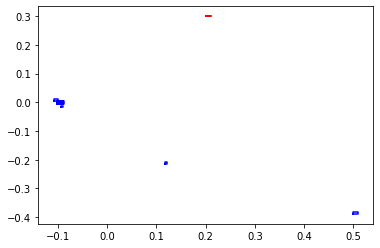

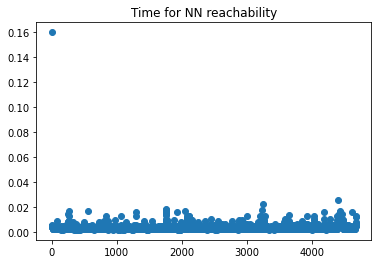

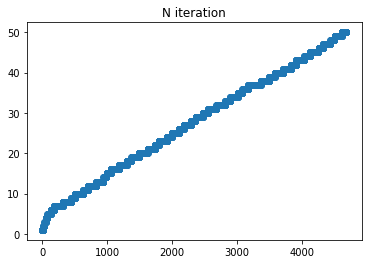

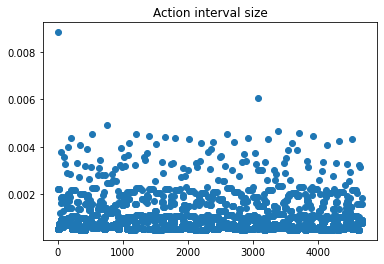

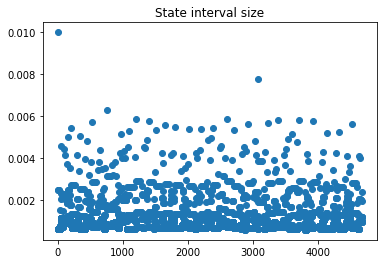

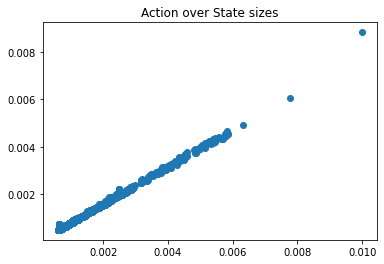

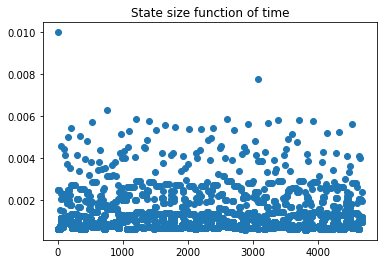

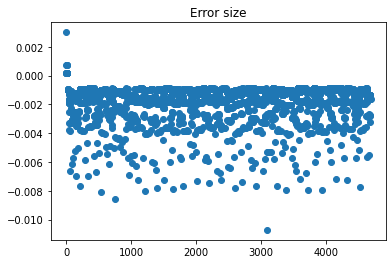

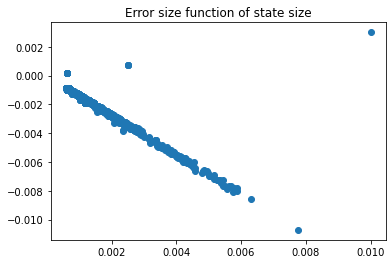

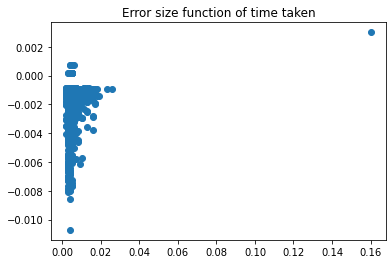

In [45]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/mpc.tf")
    state_interval = Interval(interval = [(0.2, 0.21), (0.3, 0.3)])
    epsilon=0.01
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-0.0001, 0.0001]])
    state_interval = interval_approximation(50, model, F_double_integrator, state_interval, None, epsilon, epsilon_actions=0.001, plot_jumps=1, plot=True, threshold=0.2, verbose=2, epsilon_increase="", actions_increase="uniform")

# with tf.device('/cpu:0'):
#     model = keras.models.load_model("./models/car_actor_speed_interval.tf")
#     state_interval = Interval(interval = [(-0.48, -0.478), (0.0095,0.01)])
#     epsilon= 0.1
#     specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
#     state_interval  = interval_approximation(100, model, F_car, state_interval, None, epsilon, f=reachMLP, epsilon_actions=1, plot_jumps=1, plot=True, threshold=0.1, verbose=2)

# with tf.device('/cpu:0'):
#     model = keras.models.load_model("./models/pendulum_smooth_actor3.tf")
#     state_interval = Interval(interval = [(np.pi, np.pi+0.0001), (1, 1.0001)])
#     epsilon= 0.2
#     specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
#     state_interval  = interval_approximation(60, model, F_pendulum, state_interval, None, epsilon,f=reachMLP_pendulum, epsilon_actions=0.2, plot_jumps=1, plot=True, threshold=0.2, verbose=2, epsilon_increase="", actions_increase="uniform")

In [ ]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/car_actor_speed_interval.tf")
    state_interval = Interval(interval = [(-0.48, -0.475), (0.0095,0.01)])
    epsilon= 0.0001
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
    state_interval  = interval_approximation(35, model, F_car, state_interval, None, epsilon, f=reachMLP, epsilon_actions=0.4, plot_jumps=1, plot=True, threshold=0.1, verbose=2)

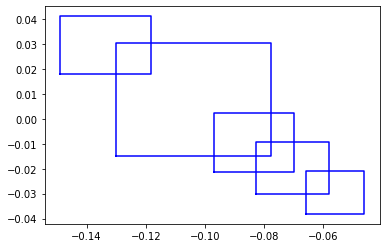

In [37]:
ax = plot_interval(state_interval[0], 0, 1)
for inter in state_interval[1:]:
    ax = add_to_plot(ax, inter, 0, 1)
plt.show()

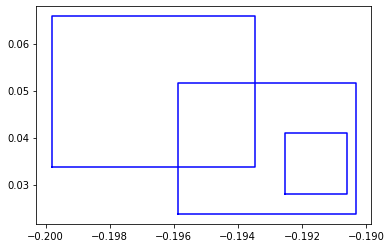

In [67]:
ax = plot_interval(state_interval[0], 0, 1)
for inter in state_interval[1:]:
    ax = add_to_plot(ax, inter, 0, 1)
plt.show()

100%|██████████| 6/6 [00:00<00:00, 352.93it/s]


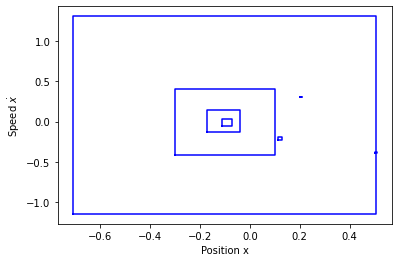

In [278]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/mpc.tf")
    state_interval = Interval(interval = [(0.2, 0.21), (0.3, 0.3)])
    epsilon=100
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-0.0001, 0.0001]])
    state_interval = interval_approximation_naive(6, model, F_double_integrator, state_interval, epsilon, plot_jumps=1)

100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


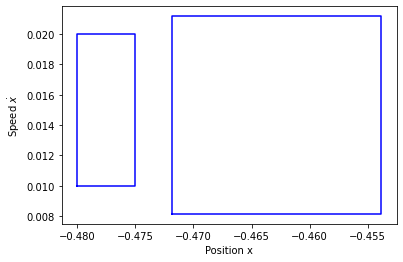

In [26]:
# model = keras.models.load_model("../ddpg/models/car_actor.tf")
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/car_actor_speed_interval.tf")
    state_interval = Interval(interval = [(-0.48, -0.475), (0.01,0.02)])
    specification_interval = Interval(interval=[[0.6, np.infty], [-0.07, 0.07]])
    epsilon = 0.01
    interval_approximation_naive(1, model, F_car, state_interval, epsilon ,plot_jumps=10)

In [ ]:
# model = keras.models.load_model("../ddpg/models/car_actor.tf")
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/car_actor_speed_interval.tf")
    state_interval = Interval(interval = [(-0.48, -0.45), (0.0095,0.01)])
    specification_interval = Interval(interval=[[0.6, np.infty], [-0.07, 0.07]])
    epsilon = 0.01
    interval_approximation(10, model, F_car, state_interval, epsilon, epsilon_states=None, plot_jumps=2)

In [ ]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/pendulum_smooth_actor3.tf")
    state_interval = Interval(interval = [(np.pi, np.pi), (1, 1)])
    epsilon=1
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
    state_interval  = interval_approximation(100, model, F_pendulum, state_interval,epsilon,plot_jumps=2, f=reachMLP_pendulum)
state_interval.intervals

100%|██████████| 30/30 [00:00<00:00, 133.54it/s]


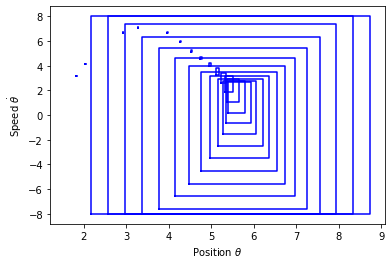

array([[ 2.16865298,  8.73092401],
       [-8.        ,  8.        ]])

In [21]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/pendulum_actor_16_small_interval.tf")
    state_interval = Interval(interval = [(np.pi/2+0.001, np.pi/2+0.005), (1.05, 1.05)])
    epsilon=1
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
    state_interval  = interval_approximation_naive(30, model, F_pendulum, state_interval,epsilon,f=reachMLP_pendulum)
state_interval.intervals